# An analysis of our electrical consumption
1. Download consumption data from https://eloverblik.dk/
1. Fix something in the CSV file (can't remember what)
1. Run the below

## Hypothesis:
1. Consumption is higher on weekend vs weekdays
1. Sunshine days will have less net consumption (leverage different data frame with weather data)
1. Winter months (due to lower sunshine hours) will have higher net consumption than summer months

## Questions: 
1. Would a battery make any difference and if so, then how much?
1. Are there months/days that the battery would not get used?
1. Is my NAS eating up KWH (I reduced time awake)

## Ideas
- Count the amount of 0 net consumption hours per day 
- Show line graph with each year as seperate color line (x-axis: day or week of year)
- 


In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Set the specific unit ID to analyse
unitid = 571313179100308524

date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
#consumption = pd.read_csv('../data/elforbrug/elforbrug_2020_2021.csv',delimiter=';',parse_dates=['Fradato'], decimal=',')
electrical_gateway = pd.read_csv('../data/elforbrug/Meterdata.csv',delimiter=';',parse_dates=['Fradato'], decimal=',', dayfirst=True)

#Unpack values into columns
electrical_gateway['HourOfDay'] = electrical_gateway['Fradato'].dt.hour
electrical_gateway['Month'] = electrical_gateway['Fradato'].dt.month
electrical_gateway['Year'] = electrical_gateway['Fradato'].dt.year
electrical_gateway['Date'] = electrical_gateway['Fradato'].dt.date
electrical_gateway['DoY'] = electrical_gateway['Fradato'].dt.dayofyear

#Filter out non-consumption
consumption = electrical_gateway.loc[electrical_gateway['MålepunktsID'] == unitid]

print('Working on ' + str(len(consumption.index)) + ' rows of data, yummy!')

len(consumption.index)

#consumption['HourOfDay'] = consumption['Fradato'].dt.hour
#consumption['Month'] = consumption['Fradato'].dt.month
#consumption['Year'] = consumption['Fradato'].dt.year
#consumption['Date'] = consumption['Fradato'].dt.date
consumption.tail()

Working on 42552 rows of data, yummy!


,MålepunktsID,Fradato,Til_dato,Forbrug,Måleenhed,Kvalitet,Type,HourOfDay,Month,Year,Date,DoY
97651,571313179100308524,2022-10-31 19:00:00,31-10-2022 20:00:00,0.31,KWH,Målt,Tidsserie,19,10,2022,2022-10-31,304
97652,571313179100308524,2022-10-31 20:00:00,31-10-2022 21:00:00,0.38,KWH,Målt,Tidsserie,20,10,2022,2022-10-31,304
97653,571313179100308524,2022-10-31 21:00:00,31-10-2022 22:00:00,0.34,KWH,Målt,Tidsserie,21,10,2022,2022-10-31,304
97654,571313179100308524,2022-10-31 22:00:00,31-10-2022 23:00:00,0.37,KWH,Målt,Tidsserie,22,10,2022,2022-10-31,304
97655,571313179100308524,2022-10-31 23:00:00,01-11-2022 00:00:00,0.35,KWH,Målt,Tidsserie,23,10,2022,2022-10-31,304


# Overall consumption
Let's see how the consumption has developed over time.
- Compare years/months to each other
- Identify the trend
- Average per day

Year,2017,2018,2019,2020,2021,2022
Month,,,,,,
1,NaN,349.63,383.10,401.11,507.06,397.56
2,NaN,274.25,292.57,351.78,447.34,320.13
3,NaN,297.26,264.51,294.66,409.78,277.26
4,NaN,192.16,196.00,245.36,302.39,223.60
5,NaN,172.41,217.18,244.23,242.47,217.03
6,NaN,118.03,165.35,201.21,191.69,176.57
7,NaN,174.85,184.12,237.00,212.20,184.66
8,NaN,182.82,214.04,234.14,250.77,208.47
9,NaN,222.87,258.87,281.17,285.05,238.29


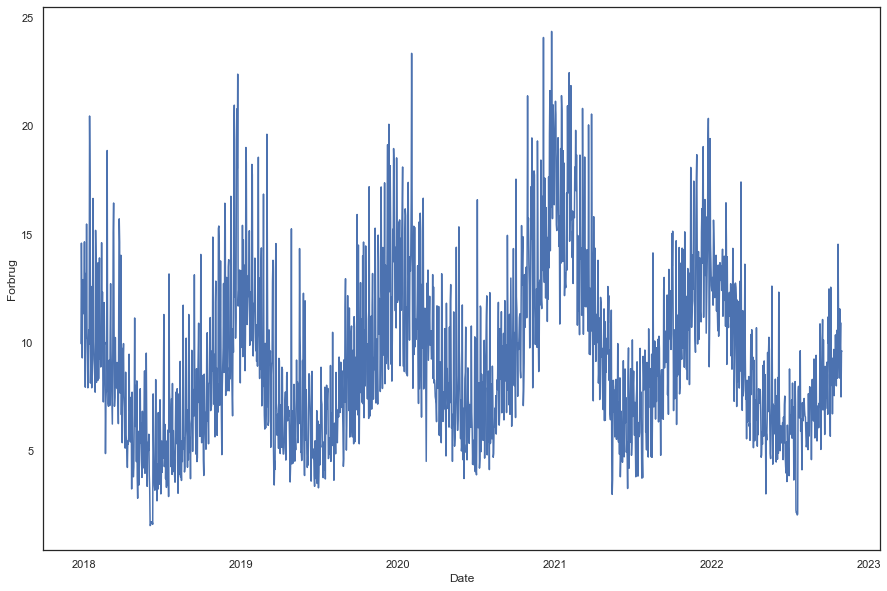

In [19]:
#Start with aggregating the data to day-level
test = pd.unique(consumption['Date'])

dayconsumption = consumption.groupby('Date').agg({'Forbrug':'sum'})

#let's plot that graph and see how bad it looks
#dayconsumption.plot()
f, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(x='Date', y='Forbrug', data=dayconsumption, ax=ax)

monthconsumption = pd.pivot_table(consumption,values='Forbrug',index=['Month'],columns='Year',aggfunc=np.sum)
monthconsumption


<AxesSubplot:xlabel='DoY'>

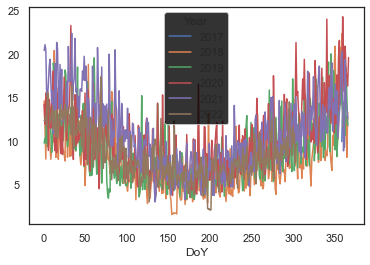

In [20]:
#Create pivot with DoY and Years as columns
DoYConsumption = pd.pivot_table(consumption,values='Forbrug',index=['DoY'],columns='Year',aggfunc=np.sum)
DoYConsumption.plot()

#TODO: Make this plot more legiable, either reduce data history or work with design

# Look at hour of day for consumption trends

## Visualise consumption distribution for a single hour slice of the day

<AxesSubplot:xlabel='Forbrug', ylabel='Density'>

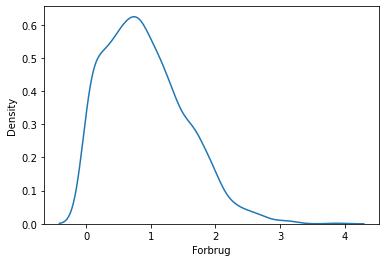

In [12]:
singlesliceofday = consumption[consumption['HourOfDay'] == 17]
sns.kdeplot(data=singlesliceofday, x='Forbrug')

### Trying to make a ridgeplot
This is to see the dispertion of consumption for each hour slice. Also they look _awesome_!

**Insight**: Hours 3 & 4 have two destinct peaks that might be worth understanding.

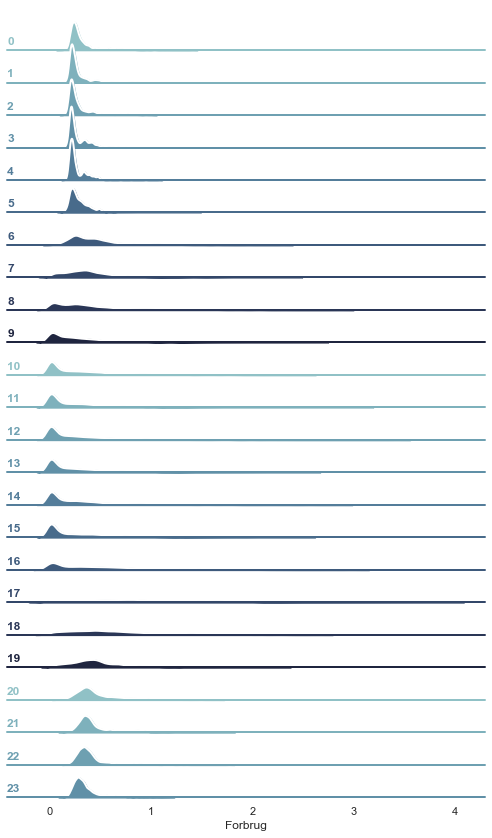

In [13]:
#https://seaborn.pydata.org/examples/kde_ridgeplot.html
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(consumption, row='HourOfDay', hue='HourOfDay', aspect=15, height=.5, palette=pal)

# g.map(sns.kdeplot, "x", bw_adjust=.5, clip_on=False,fill=True, alpha=1, linewidth=1.5)
#sns.kdeplot(data=singlesliceofday, x='Forbrug')
g.map(sns.kdeplot, 'Forbrug', bw_adjust=.5, clip_on=False,fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, 'Forbrug', clip_on=False, color="w", lw=2, bw_adjust=.5)

g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, 'Forbrug')

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

Do the same with Violin for higher fidelity?

## Understanding how share of consumption is split by day (for all days)

<AxesSubplot:ylabel='HourOfDay'>

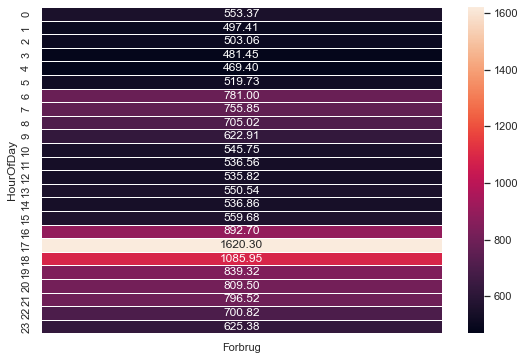

In [14]:
aggrPerHour = consumption.pivot_table(index = ['HourOfDay'], values = 'Forbrug', aggfunc=np.sum )
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(aggrPerHour, annot=True, fmt='.2f', linewidths=.5, ax=ax)

## Show heatmap of consumption split on day of week (0 = Monday) and hour of day
Here showing average

/var/folders/l7/_8vcgcf9421_1drcl53nf84h0000gn/T/ipykernel_46342/1823444192.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consumption['NamedDayOfWeek'] = consumption['Fradato'].dt.day_name()
/var/folders/l7/_8vcgcf9421_1drcl53nf84h0000gn/T/ipykernel_46342/1823444192.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consumption['DayOfWeek'] = consumption['Fradato'].dt.dayofweek


<AxesSubplot:xlabel='DayOfWeek', ylabel='HourOfDay'>

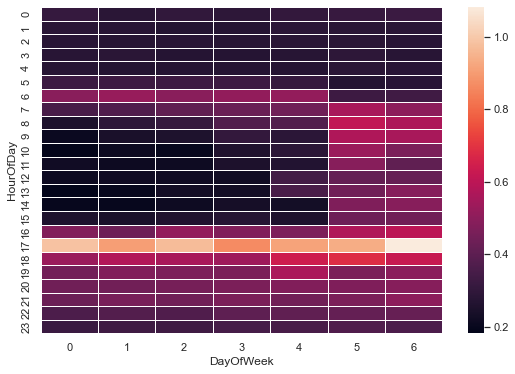

In [13]:

sns.set_theme(style="darkgrid")

#Annotate day of week
consumption['NamedDayOfWeek'] = consumption['Fradato'].dt.day_name()
consumption['DayOfWeek'] = consumption['Fradato'].dt.dayofweek

conspivot = consumption.pivot_table(index = ['HourOfDay'], columns =['DayOfWeek'], values = 'Forbrug', aggfunc=np.average )

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(conspivot, annot=False, fmt='f', linewidths=.5, ax=ax)

Here showing aggregate value

<AxesSubplot:xlabel='DayOfWeek', ylabel='HourOfDay'>

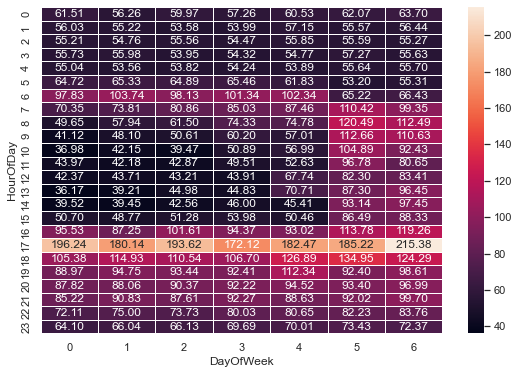

In [14]:
conspivot = consumption.pivot_table(index = ['HourOfDay'], columns =['DayOfWeek'], values = 'Forbrug', aggfunc=np.sum )

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(conspivot, annot=True, fmt='.2f', linewidths=.5, ax=ax)

That was sad. :-(


# Now looking for spots with ZERO net consumption
This is what we are here for! 

In [15]:
zeroCons = consumption[consumption['Forbrug'] == 0]

print('There are ' + str(len(zeroCons.index)) + ' hour slices with **ZERO** net consumption!!!')
print('That is ' + str(len(zeroCons.index)/len(consumption.index)*100) + '% !!!')

There are 1576 hour slices with **ZERO** net consumption!!!
That is 3.7037037037037033% !!!


Lets look at when they fall

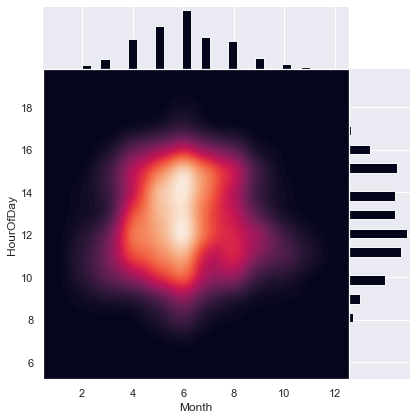

In [16]:
#https://seaborn.pydata.org/examples/smooth_bivariate_kde.html

g = sns.JointGrid(data=zeroCons, x='Month', y='HourOfDay', space=0)
g.plot_joint(sns.kdeplot,
             fill=True, 
             thresh=0, levels=100, cmap="rocket")
g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=25)

What does the consumption look like just after these famed **ZERO** consumption periods? 

If they are low then maybe a battery could tide us over and save us some money! 

## Let's look at almost zero consumption
Maybe there are many more?

There are 6540 hour-slices with less than 100W net consumption!!!
That is 15.369430344049634% !!!


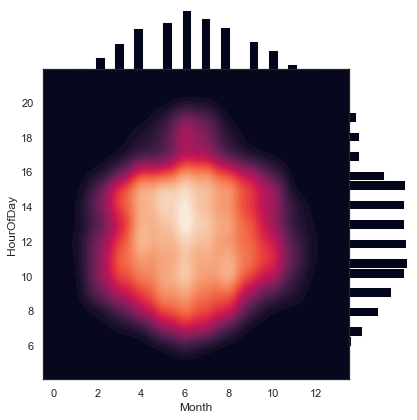

In [16]:
almostzero = consumption[consumption['Forbrug'] < 0.1]
print('There are ' + str(len(almostzero.index)) + ' hour-slices with less than 100Wh net consumption!!!')
print('That is ' + str(len(almostzero.index)/len(consumption.index)*100) + '% !!!')

g = sns.JointGrid(data=almostzero, x='Month', y='HourOfDay', space=0)
g.plot_joint(sns.kdeplot,
             fill=True, 
             thresh=0, levels=100, cmap="rocket")
g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=25)